In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from torch import nn, optim

import torch.nn.functional as F
from tqdm import tqdm

torch.manual_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
df = pd.read_csv(r"D:\Uptime AI\Uptime AI\baldwin_pump_data.csv")
df.head()

,Time Step,BFP_SEAL_WATER_FLOW,BFP_SUCT_HDR_PRESS________,AUX_CDSR_2B_PRESS_________,BFP_SUCTION_HDR_TEMP______,BFPT_B_VALVE_DEMAND_HP_STO,BFPT_B_VALVE_DEMAND_LP_STO,BFPT_B_CALC_VALVE_DEMAND__,2B_TDBFP_RECIRC_VLV_DMD___,BFP_2B_DISCHARGE_FLOW_____,...,BFPT_2B_RAD_SHAFT_VIB_IB_B,BFP_2B_AXIAL_SHAFT_VIB____,BFPT_2B_THRUST_BRG_WEAR___,BFP_2B_RAD_SHAFT_VIB_OB_BR,BFP_2B_RAD_SHAFT_VIB_IB_BR,BFPT_2B_AXIAL_SHAFT_VIB___,MAIN_STEAM_FLOW_TO_BFPS___,EXT_STM_FLOW_TO_BFP_2B____,CW_FRM_AUX_CDSR_2B________,CW_TO_AUX_CDS_2B
0,5/1/98 0:00,14.35,136.18,29.2,88.57,0.01,0.0,0.0,99.98,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,68.11,65.72
1,5/1/98 0:05,14.35,136.18,29.2,88.57,0.01,0.0,0.0,99.98,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,68.11,65.72
2,5/1/98 0:10,14.35,136.18,29.2,88.57,0.01,0.0,0.0,99.98,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,68.11,65.72
3,5/1/98 0:15,14.35,136.18,29.2,88.57,0.01,0.0,0.0,99.98,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,68.11,65.72
4,5/1/98 0:20,14.34,136.18,29.2,88.57,0.01,0.0,0.0,99.98,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,68.11,65.72


In [4]:
df.shape #So total 12661 rows and 48 feature columns along with time step column

(12661, 48)

In [5]:
#Number of shutdown conditions in the data
l = 0
for d in df.BFPT_B_LP_SPEED_INPUT__1__ == 0.0:
    if d:
        l+=1
print(l)

6237


In [6]:
df = df.drop(df[df.BFPT_B_LP_SPEED_INPUT__1__ == 0.0].index)
# print(len(df)) #length of dataframe after removing the shutdown conditions
df.interpolate(method='linear', limit_direction='backward', axis=0,inplace=True)
df.fillna(df.mean(),inplace=True)
# df.fillna(0.0,inplace=True)

In [7]:
df.isna().any().value_counts()
#No NaN values in all columns

False    48
dtype: int64

In [8]:
#Splitting the data into train and validation
train_df, val_df = train_test_split(df,test_size=0.33,random_state=42,shuffle=False)
val_df,test_df = train_test_split(val_df,test_size=0.15,random_state=42,shuffle=True)

In [9]:
train_df.drop(columns=['Time Step'],inplace=True)
val_df.drop(columns=['Time Step'],inplace=True)
test_df.drop(columns=['Time Step'],inplace=True)

C:\Users\astar\anaconda3\envs\PyTorch\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
def normalize_data(df):
    scaler = MinMaxScaler(feature_range=(0,1))
    df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
    return df,scaler

In [11]:
# train_df,scaler_train = normalize_data(train_df)
# val_df,scaler_val = normalize_data(val_df)
# test_df,scaler_test = normalize_data(test_df)

In [12]:
train_dataset = torch.Tensor(train_df.values)
val_dataset = torch.Tensor(val_df.values)
test_dataset = torch.Tensor(test_df.values)

In [13]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

In [14]:
for i in train_loader:
    n_features = i.shape[1] #Every object has a shape of (batch_size,number_of_features)
    break
n_features

47

In [15]:
#Encoder Decoder for AutoEncoder model
class Encoder(nn.Module):
    def __init__(self,batch_size,n_features,embedding_dim):
        super(Encoder,self).__init__()

        self.batch_size = batch_size
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = embedding_dim*2

        self.rnn1 = nn.LSTM(
            input_size = n_features,
            hidden_size = self.hidden_dim,
            num_layers = 3, dropout = 0.3
        )
        self.rnn2 = nn.LSTM(
            input_size = self.hidden_dim,
            hidden_size = self.embedding_dim,
            num_layers = 1
        )
        
        (hidden_n,cell_n) = (torch.zeros(1,self.batch_size,self.hidden_dim),torch.zeros(1,self.batch_size,self.hidden_dim))
    
    def forward(self,x):
        
        x = x.unsqueeze(0)
        # print(x.size())
        x, (hidden_n,cell_n) = self.rnn1(x)
        x, (hidden_n,cell_n) = self.rnn2(x)
        # print(hidden_n.size())

        return hidden_n.reshape((1,-1,self.embedding_dim))

class Decoder(nn.Module):
    def __init__(self,batch_size,input_dim,output_dim=n_features): #input_dim is same as the embedding dimension
        super(Decoder,self).__init__()

        self.batch_size, self.input_dim = batch_size, input_dim
        self.hidden_dim = input_dim * 2
        self.output_dim = output_dim

        self.rnn1 = nn.LSTM(
            input_size = input_dim,
            hidden_size = input_dim,
            num_layers = 3,dropout = 0.3)

        self.rnn2 = nn.LSTM(
            input_size = input_dim,
            hidden_size =self.hidden_dim,
            num_layers = 1)

        self.dense_layers = nn.Linear(self.hidden_dim,output_dim)

    def forward(self,x):

        x, (hidden_n,cell_n) = self.rnn1(x)
        x, (hidden_n,cell_n) = self.rnn2(x)
        x = x.reshape((-1,self.hidden_dim))

        return self.dense_layers(x)

In [16]:
class RAE(nn.Module):
    def __init__(self,batch_size,n_features,embedding_dim):
        super(RAE,self).__init__()

        self.batch_size, self.n_features = batch_size, n_features
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(batch_size,n_features,embedding_dim).to(device)
        self.decoder = Decoder(batch_size,embedding_dim).to(device)
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [17]:
model = RAE(batch_size,n_features,embedding_dim=96)
model = model.to(device)

In [18]:
model

RAE(
  (encoder): Encoder(
    (rnn1): LSTM(47, 192, num_layers=3)
    (rnn2): LSTM(192, 96)
  )
  (decoder): Decoder(
    (rnn1): LSTM(96, 96, num_layers=3)
    (rnn2): LSTM(96, 192)
    (dense_layers): Linear(in_features=192, out_features=47, bias=True)
  )
)

In [19]:
seed = 42
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True

seed_torch(seed)

In [20]:
def train_model(model,train_dataset,val_dataset,n_epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
    criterion = nn.L1Loss(reduction='mean').to(device)

    history = dict(train=[],val=[])

    for epoch in (range(1,n_epochs+1)):
        model = model.train()

        train_losses = []

        for seq_true in train_loader:
            optimizer.zero_grad()
            seq_true = seq_true.to(device)

            seq_pred = model(seq_true)
            loss = criterion(seq_pred,seq_true) #reconstruction loss
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
        val_losses = []
        model = model.eval()
        criterion_val = nn.L1Loss(reduction='mean').to(device)
        with torch.no_grad():
            for seq_true in val_loader:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion_val(seq_pred,seq_true)
                
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        print(f'Epoch {epoch} the train loss {train_loss} and validation loss is {val_loss}')
    return model.eval(), history

In [21]:
model,history = train_model(model,train_dataset,val_dataset,n_epochs=20)

Epoch 1 the train loss 350.6121526668506 and validation loss is 292.9405955061664
Epoch 2 the train loss 297.7338163808376 and validation loss is 265.80214461687535
Epoch 3 the train loss 264.565413521125 and validation loss is 239.30614811836946
Epoch 4 the train loss 231.48516596116986 and validation loss is 213.17368107921672
Epoch 5 the train loss 199.49271026951672 and validation loss is 190.26912803946271
Epoch 6 the train loss 173.21481777035171 and validation loss is 173.03029394626088
Epoch 7 the train loss 152.54650476164977 and validation loss is 157.6888897352822
Epoch 8 the train loss 135.29727260773953 and validation loss is 146.1294762021826
Epoch 9 the train loss 121.8315823352913 and validation loss is 136.5330146256086
Epoch 10 the train loss 109.09440553232639 and validation loss is 126.9373904534106
Epoch 11 the train loss 96.36535518320076 and validation loss is 117.26157992423309
Epoch 12 the train loss 83.66238973397748 and validation loss is 107.55807474159639
E

In [22]:
torch.save(model, 'Batched.pt')

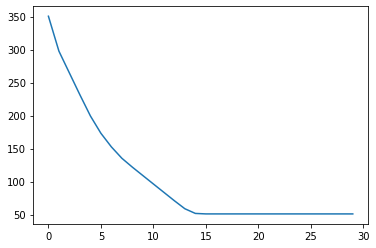

In [23]:
import matplotlib.pyplot as plt
plt.plot(history['train'])

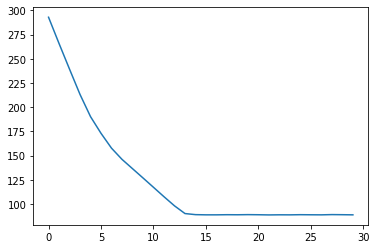

In [24]:
plt.plot(history['val'])

In [25]:
def predict(model,test_loader):
    predictions,losses = [],[]
    criterion = nn.L1Loss(reduction='mean').to(device)
    seqs = []
    with torch.no_grad():
        model = model.eval()
        for seq_true in test_loader:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred,seq_true)
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses, seqs

_, losses, seqs = predict(model,test_loader)

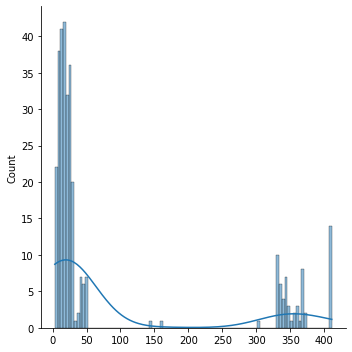

In [26]:
sns.displot(losses,bins=100,kde=True)

In [27]:
def anomalies_count(losses,delta):
    threshold = sum(losses)/len(losses) + delta
    count = 0
    for loss in losses:
        if loss >= threshold:
            count+=1
    return count

In [28]:
c = anomalies_count(losses,delta=100)
c

62